In [2]:
import scipy.io
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline
%config InlineBackend.figure_formats = set(['retina'])

import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

In [3]:
data = scipy.io.loadmat("Accelerometer_data.mat")
print(data.keys())

x_train = np.hstack((data['train']['ax'][0,0], 
                     data['train']['ay'][0,0], 
                     data['train']['az'][0,0]))
y_train = data['train']['Y'][0,0].reshape(-1)

x_test = np.hstack((data['test']['ax'][0,0], 
                    data['test']['ay'][0,0], 
                    data['test']['az'][0,0]))
y_test = data['test']['Y'][0,0].reshape(-1)

actnames = ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing', 'Laying']

dict_keys(['__header__', '__version__', '__globals__', 'actnames', 'fs', 'test', 'train'])


In [40]:
x_train.shape

(1442, 384)

In [5]:
x_test.shape[0]

618

In [6]:
1442/7

206.0

In [7]:
628/3

209.33333333333334

### Try k-NN in time domain

In [3]:
clf1 = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf1.fit(x_train, y_train)
y_pred_1 = clf1.predict(x_test)
print('Accuracy for k=1: ' + str(accuracy_score(y_test, y_pred_1)))

Accuracy for k=1: 0.7233009708737864


In [4]:
clf3 = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf3.fit(x_train, y_train)
y_pred_3 = clf3.predict(x_test)
print('Accuracy for k=3: ' + str(accuracy_score(y_test, y_pred_3)))

Accuracy for k=3: 0.6456310679611651


In [5]:
clf5 = KNeighborsClassifier(n_neighbors = 5, algorithm="brute")
clf5.fit(x_train, y_train)
y_pred_5 = clf5.predict(x_test)
print('Accuracy for k=5: ' + str(accuracy_score(y_test, y_pred_5)))

Accuracy for k=5: 0.6116504854368932


Confusion matrix for k=1:


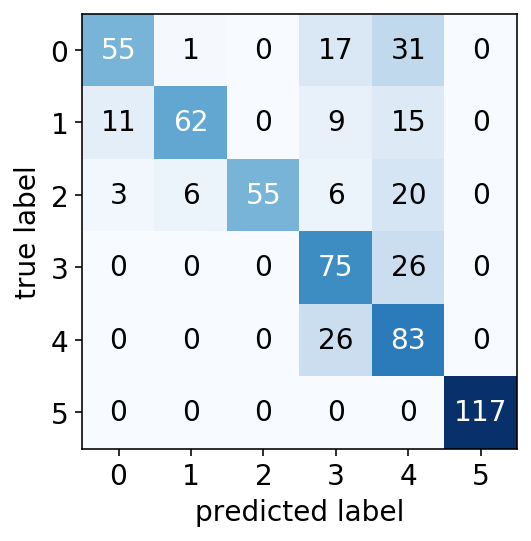

In [6]:
matplotlib.rcParams['figure.figsize'] = (4, 4)
matplotlib.rcParams.update({'font.size': 14})

confMatrix1 = confusion_matrix(y_test, y_pred_1)
print('Confusion matrix for k=1:')
fig, ax = plot_confusion_matrix(confMatrix1)
plt.show()


### Try applying Discrete Fourier Transform (DFT)

k-NN in frequency domain

In [66]:
def buildX(set):
    ax_dft = np.fft.fft(data[set]['ax'][0,0], axis = 1)
    ay_dft = np.fft.fft(data[set]['ay'][0,0], axis = 1)
    az_dft = np.fft.fft(data[set]['az'][0,0], axis = 1)
    return np.absolute(np.hstack((ax_dft, ay_dft, az_dft)))

In [67]:
x_train_dft = buildX('train')
x_test_dft = buildX('test')

Accuracy for DFT: 0.8284789644012945
Confusion matrix for k=1:


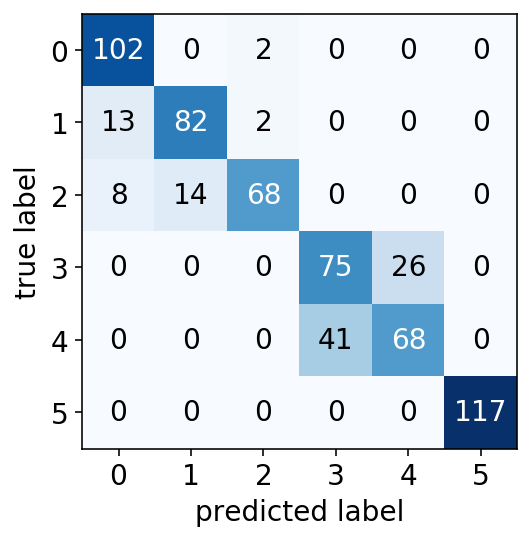

In [9]:
clf_dft = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf_dft.fit(x_train_dft, y_train)
y_pred_dft = clf_dft.predict(x_test_dft)
print('Accuracy for DFT: ' + str(accuracy_score(y_test, y_pred_dft)))

confMatrix2 = confusion_matrix(y_test, y_pred_dft)
print('Confusion matrix for k=1:')
fig, ax = plot_confusion_matrix(confMatrix2)
plt.show()

### Try XGB
Use a very naive gradient boosting tree model with frequency domain inputs. The inputs now includes both the magnitudes and the angles of DFT of signals.

In [10]:
import xgboost as xgb

In [11]:
def buildAngleX(set):
    ax_dft = np.fft.fft(data[set]['ax'][0,0], axis = 1)
    ay_dft = np.fft.fft(data[set]['ay'][0,0], axis = 1)
    az_dft = np.fft.fft(data[set]['az'][0,0], axis = 1)
    return np.angle(np.hstack((ax_dft, ay_dft, az_dft)))

In [12]:
x_train_xgb = np.hstack((x_train_dft, buildAngleX('train')))
x_test_xgb = np.hstack((x_test_dft, buildAngleX('test')))

In [13]:
dtrain = xgb.DMatrix(x_train_xgb, label = y_train-1)
dtest = xgb.DMatrix(x_test_xgb, label = y_test-1)

param = {'objective': 'multi:softmax',
         'num_class': 6,
         'eval_metric': 'merror',
         'silent': 1}

evallist = [(dtrain, 'train'), (dtest, 'eval')]

In [14]:
num_round = 100
bst = xgb.train(param, dtrain, num_round, evallist, early_stopping_rounds=10, verbose_eval= 10)
# Using the test set to early stop in order to avoid over-fitting

[0]	train-merror:0.033287	eval-merror:0.192557
Multiple eval metrics have been passed: 'eval-merror' will be used for early stopping.

Will train until eval-merror hasn't improved in 10 rounds.
[10]	train-merror:0.002774	eval-merror:0.156958
[20]	train-merror:0	eval-merror:0.142395
[30]	train-merror:0	eval-merror:0.134304
[40]	train-merror:0	eval-merror:0.12945
[50]	train-merror:0	eval-merror:0.134304
Stopping. Best iteration:
[40]	train-merror:0	eval-merror:0.12945



Accuracy for XGB: 0.8656957928802589
Confusion matrix for XGB:


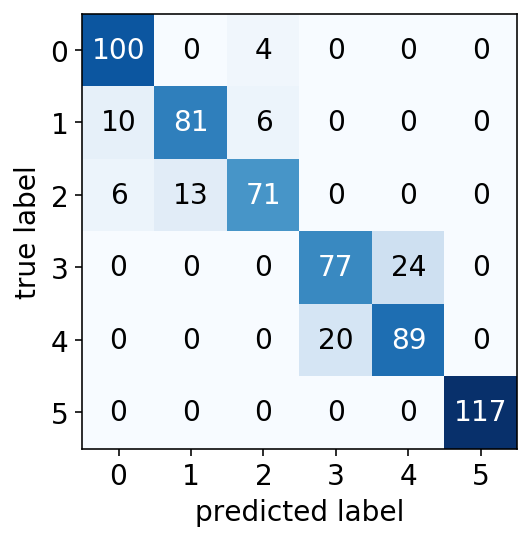

In [15]:
y_pred_xgb = bst.predict(dtest) + 1
print('Accuracy for XGB: ' + str(accuracy_score(y_test, y_pred_xgb)))
confMatrix3 = confusion_matrix(y_test, y_pred_xgb)
print('Confusion matrix for XGB:')
fig, ax = plot_confusion_matrix(confMatrix3)
plt.show()

### Apply high-pass filter on az

Gravity has a significant component along z axis, we will use a high pass filter to remove this.

#### First try k-NN on filted data in time domain

In [15]:
import scipy.signal
import scipy.io
matplotlib.rcParams.update({'font.size': 14})

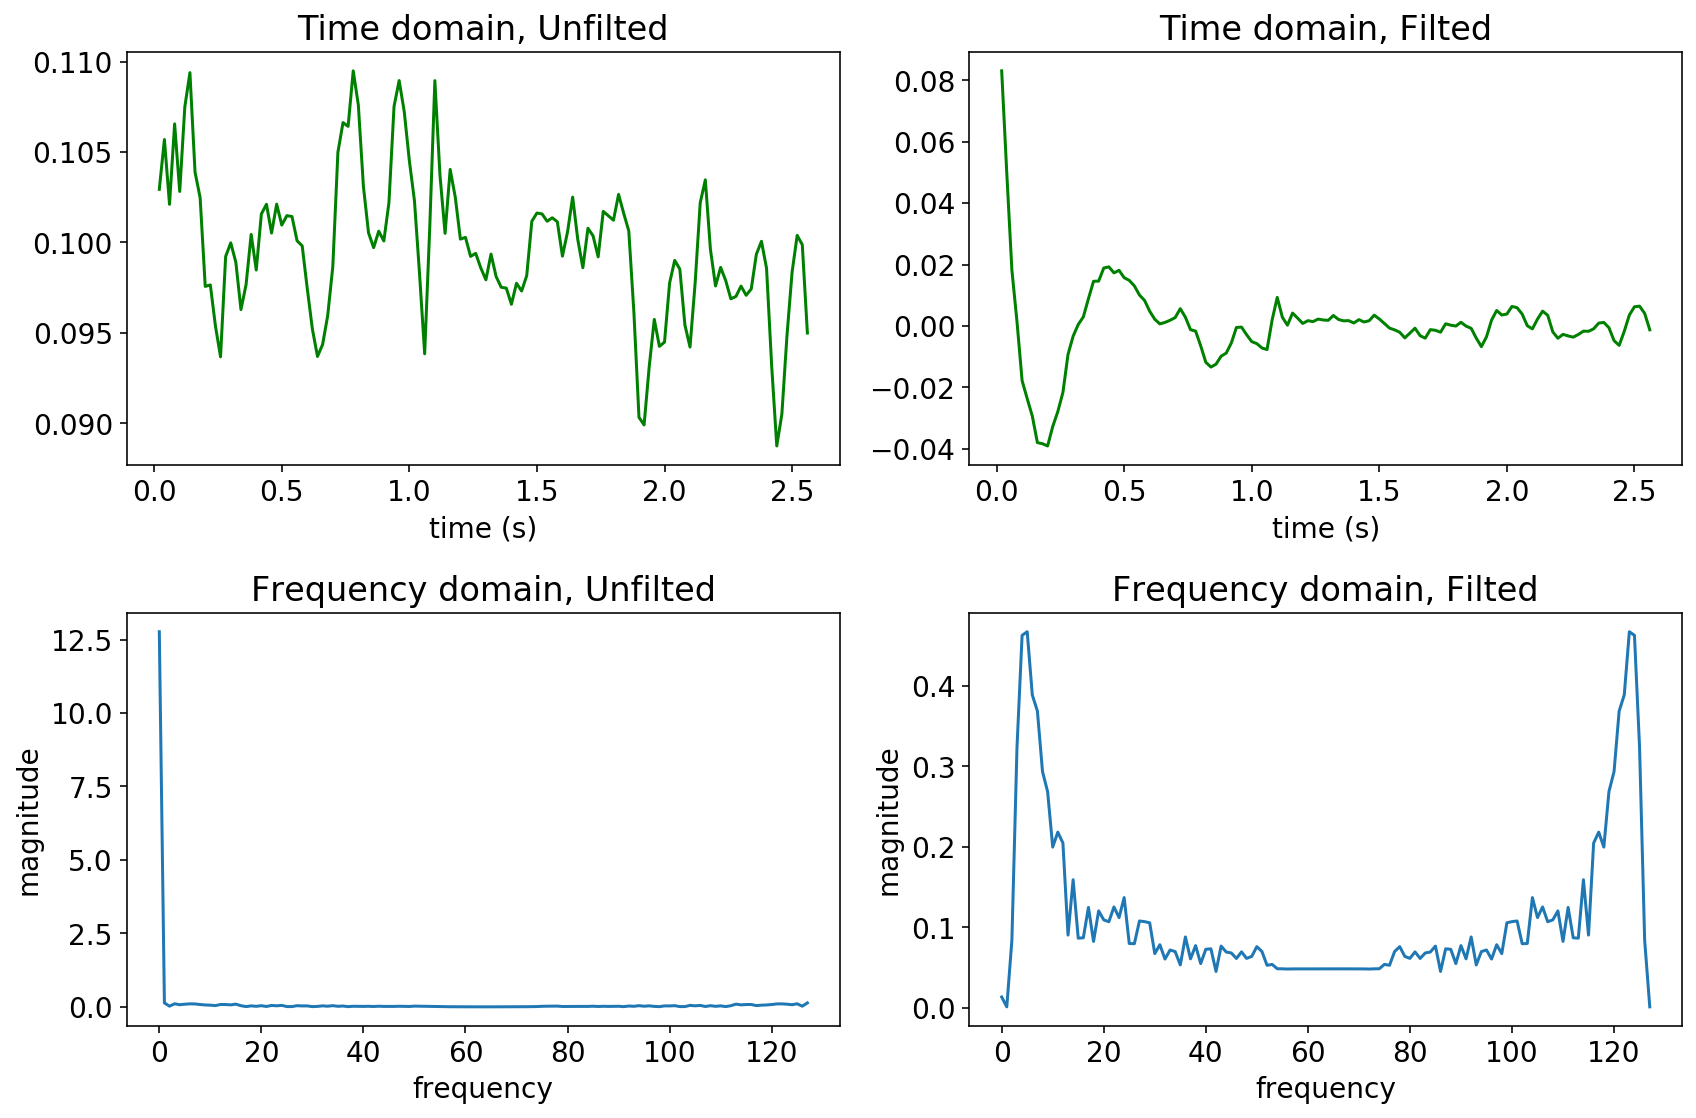

In [37]:
matplotlib.rcParams['figure.figsize'] = (12, 8)

b,a = scipy.signal.cheby2(N = 4, rs = 60, Wn = 0.4, btype = "highpass", output = "ba", fs = 50)
train_data_0 = data['train']['az'][0,0][0,:]
train_data_0_filted = scipy.signal.lfilter(b,a,train_data_0)

dft = np.fft.fft(train_data_0)
dft_filted = np.fft.fft(train_data_0_filted)

t = np.arange(1,129)/50
plt.subplot(2,2,1)
plt.plot(t,train_data_0, 'g')
plt.title('Time domain, Unfilted')
plt.xlabel('time (s)')

plt.subplot(2,2,2)
plt.plot(t, train_data_0_filted, 'g')
plt.title('Time domain, Filted')
plt.xlabel('time (s)')


plt.subplot(2,2,3)
plt.plot(np.absolute(dft))
plt.title('Frequency domain, Unfilted')
plt.xlabel('frequency')
plt.ylabel('magnitude')

plt.subplot(2,2,4)
plt.plot(np.absolute(dft_filted))
plt.title('Frequency domain, Filted')
plt.xlabel('frequency')
plt.ylabel('magnitude')

plt.tight_layout()
plt.savefig('filtering.eps')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


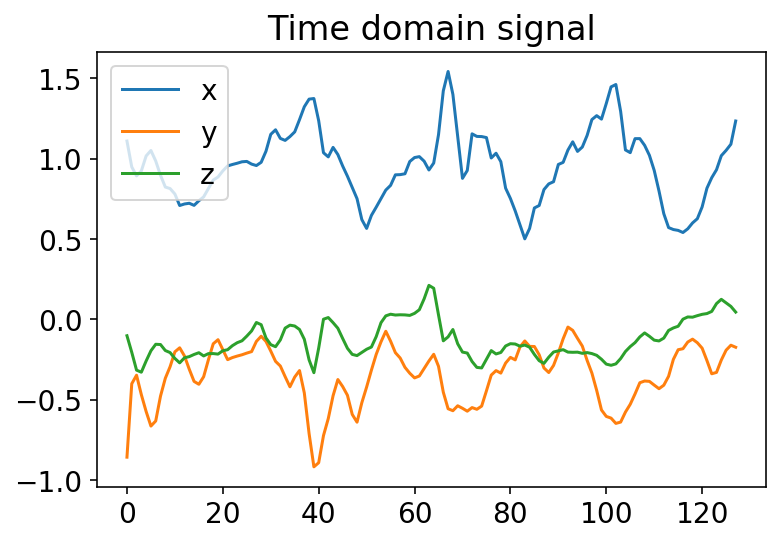

In [34]:
matplotlib.rcParams['figure.figsize'] = (6, 4)
matplotlib.rcParams.update({'font.size': 14})
train_data_0 = data['train']['ax'][0,0][100,:]
train_data_1 = data['train']['ay'][0,0][100,:]
train_data_2 = data['train']['az'][0,0][100,:]
plt.plot(train_data_0, label = 'x')
plt.plot(train_data_1, label = 'y')
plt.plot(train_data_2, label = 'z')
plt.title('Time domain signal')
plt.legend(loc = 'upper left')
plt.savefig('signal.eps')

In [18]:
x_train = np.hstack((data['train']['ax'][0,0], 
                     data['train']['ay'][0,0], 
                     data['train']['az'][0,0]))
y_train = data['train']['Y'][0,0].reshape(-1)

x_test = np.hstack((data['test']['ax'][0,0], 
                    data['test']['ay'][0,0], 
                    data['test']['az'][0,0]))
y_test = data['test']['Y'][0,0].reshape(-1)

train_az_filted = scipy.signal.lfilter(b,a,data['train']['az'][0,0])
test_az_filted = scipy.signal.lfilter(b,a,data['test']['az'][0,0])

x_train_filted = np.hstack((data['train']['ax'][0,0], 
                     data['train']['ay'][0,0], 
                     train_az_filted))

x_test_filted = np.hstack((data['test']['ax'][0,0], 
                    data['test']['ay'][0,0], 
                    test_az_filted))

In [19]:
clf1_filted = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf1_filted.fit(x_train_filted, y_train)
y_pred_1_filted = clf1_filted.predict(x_test_filted)
print('Accuracy for k=1, trained with filtered data: ' + str(accuracy_score(y_test, y_pred_1_filted)))

clf3_filted = KNeighborsClassifier(n_neighbors = 3, algorithm="brute")
clf3_filted.fit(x_train_filted, y_train)
y_pred_3_filted = clf3_filted.predict(x_test_filted)
print('Accuracy for k=3, trained with filtered data: ' + str(accuracy_score(y_test, y_pred_3_filted)))

clf5_filted = KNeighborsClassifier(n_neighbors = 5, algorithm="brute")
clf5_filted.fit(x_train_filted, y_train)
y_pred_5_filted = clf5_filted.predict(x_test_filted)
print('Accuracy for k=5, trained with filtered data: ' + str(accuracy_score(y_test, y_pred_5_filted)))

Accuracy for k=1, trained with filtered data: 0.7815533980582524
Accuracy for k=3, trained with filtered data: 0.7103559870550162
Accuracy for k=5, trained with filtered data: 0.6812297734627831


Confusion matrix:


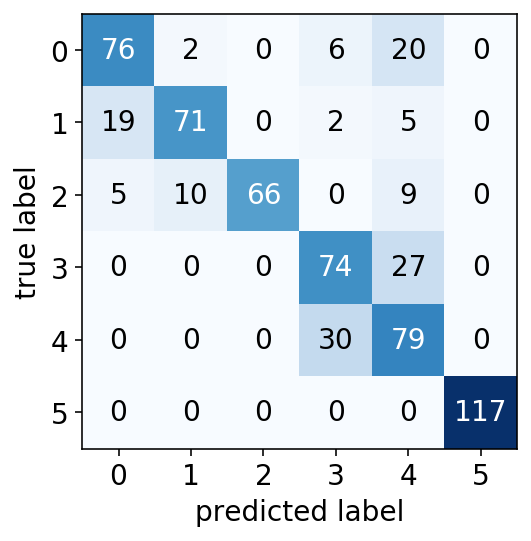

In [20]:
matplotlib.rcParams['figure.figsize'] = (4, 4)
confMatrix4 = confusion_matrix(y_test, y_pred_1_filted)
print('Confusion matrix:')
fig, ax = plot_confusion_matrix(confMatrix4)
plt.show()

#### Try k-NN on filted data in frequency domain

In [21]:
def buildX(set, filted = False):
    ax_dft = np.fft.fft(data[set]['ax'][0,0], axis = 1)
    ay_dft = np.fft.fft(data[set]['ay'][0,0], axis = 1)
    if filted:
        az_filted = scipy.signal.lfilter(b,a,data[set]['az'][0,0])
        az_dft = np.fft.fft(az_filted, axis = 1)
    else:
        az_dft = np.fft.fft(data[set]['az'][0,0], axis = 1)
    return np.absolute(np.hstack((ax_dft, ay_dft, az_dft)))

Accuracy for DFT, trained with filtered data: 0.8122977346278317
Confusion matrix:


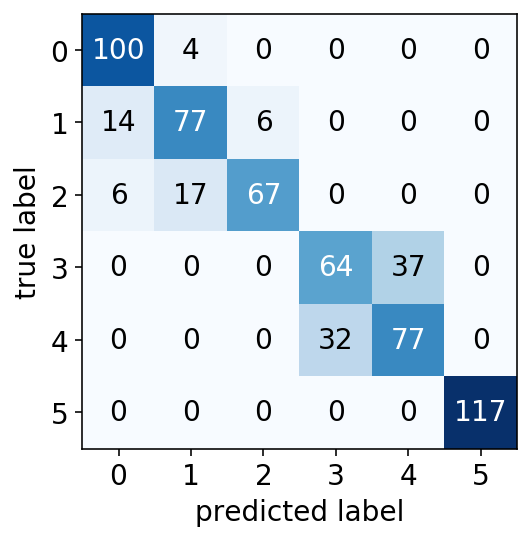

In [22]:
x_train_dft = buildX('train')
x_test_dft = buildX('test')
x_train_filted_dft = buildX('train', filted = True)
x_test_filted_dft = buildX('test', filted = True)

clf_filted_dft = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf_filted_dft.fit(x_train_filted_dft, y_train)
y_pred_filted_dft = clf_filted_dft.predict(x_test_filted_dft)
print('Accuracy for DFT, trained with filtered data: ' + str(accuracy_score(y_test, y_pred_filted_dft)))

matplotlib.rcParams['figure.figsize'] = (4, 4)
confMatrix5 = confusion_matrix(y_test, y_pred_filted_dft)
print('Confusion matrix:')
fig, ax = plot_confusion_matrix(confMatrix5)
plt.show()

Accuracy droped when apply DFT to filted data!

### Try dimension reduction technique

Apply Fisher's LDA

In [69]:
from scipy.linalg import eig
from mpl_toolkits.mplot3d import Axes3D

In [44]:
def getGenEig(A, B):
    R = np.linalg.cholesky(B)
    R_inv = np.linalg.inv(R)
    eigenval_, eigenvec_ = eig(R_inv @ A @ R_inv.T)
    eigenvec_ = R_inv.T @ eigenvec_
    eigenvec_ = eigenvec_ / np.linalg.norm(eigenvec_, axis = 0)
    return eigenval_, eigenvec_

In [82]:
x_train = np.hstack((data['train']['ax'][0,0], 
                     data['train']['ay'][0,0], 
                     data['train']['az'][0,0]))
y_train = data['train']['Y'][0,0].reshape(-1)

SW = 0
SB = 0
mu = np.mean(x_train, axis = 0)

for i in range(1,7):
    x_slice = x_train[y_train == i,:]
    mu_i = np.mean(x_slice, axis = 0)
    x_slice -= mu_i
    SW += x_slice.T @ x_slice
    SB += x_slice.shape[0] * np.outer(mu_i-mu, mu_i-mu)
    
eigenval, eigenvec = getGenEig(SB, SW)
idx = eigenval.argsort()[::-1]
A = np.real(eigenvec[:, idx])[:,:3]
x_lowDim = x_train @ A

In [70]:
def fisher_LDA(x_train, y_train, n_dim = 3):
    SW = 0
    SB = 0
    mu = np.mean(x_train, axis = 0)

    for i in range(1,7):
        x_slice = x_train[y_train == i,:]
        mu_i = np.mean(x_slice, axis = 0)
        x_slice -= mu_i
        SW += x_slice.T @ x_slice
        SB += x_slice.shape[0] * np.outer(mu_i-mu, mu_i-mu)

    eigenval, eigenvec = eig(SB, SW)
    idx = eigenval.argsort()[::-1]
    A = np.real(eigenvec[:, idx])[:,:n_dim]
    return A

In [71]:
A = fisher_LDA(x_train_, y_train, n_dim = 3)
x_lowDim = x_train_dft @ A

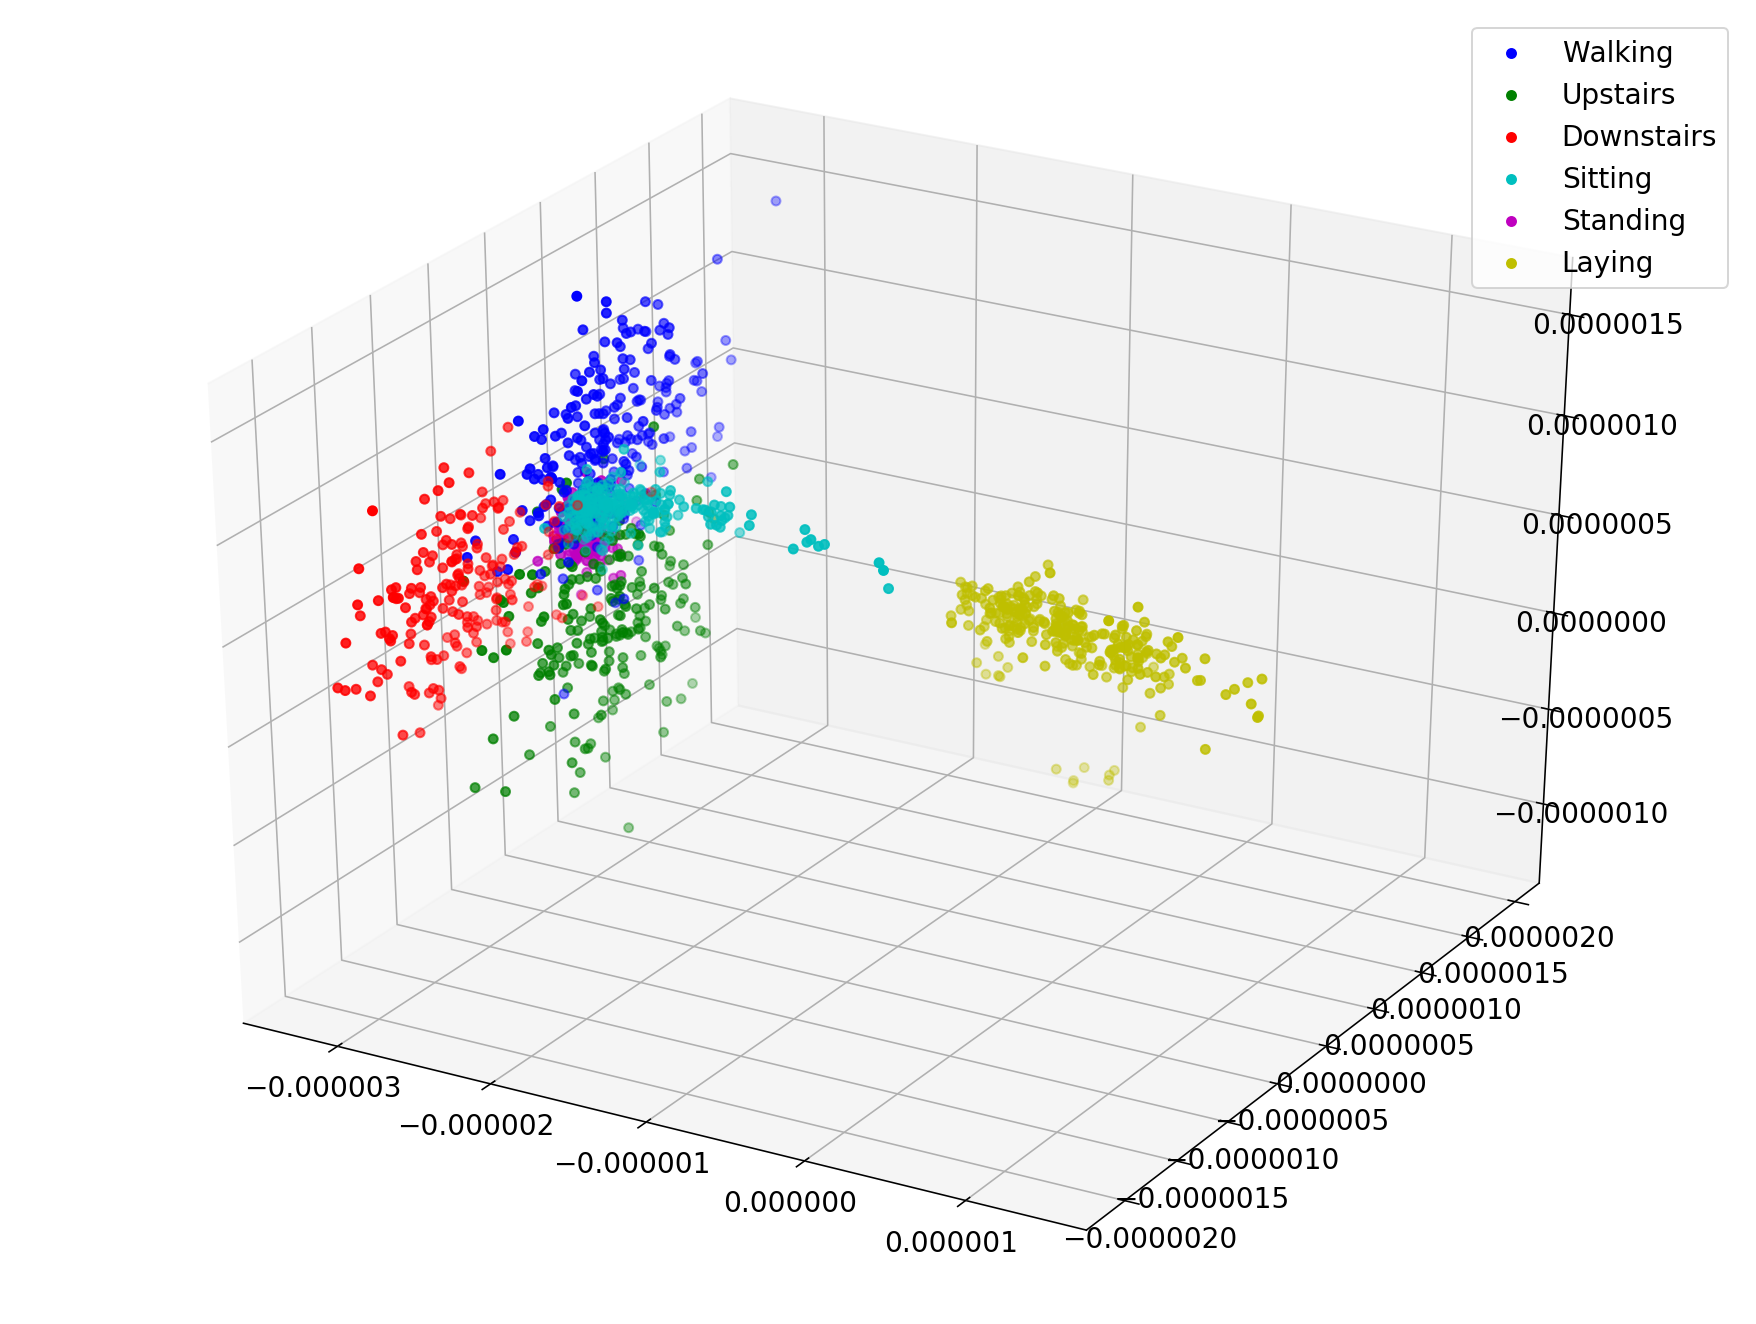

In [98]:
matplotlib.rcParams['figure.figsize'] = (12, 9)
matplotlib.rcParams.update({'font.size': 14})

COLORS = ['b', 'g', 'r', 'c', 'm', 'y']
LABELS = ['Walking', 'Upstairs', 'Downstairs', 'Sitting', 'Standing', 'Laying']

fig = plt.figure()
ax = Axes3D(fig)

for i in range(1,7):
    x_slice = x_lowDim[y_train == i,:]
    ax.scatter(x_slice[:,0], x_slice[:,1], x_slice[:,2], c = COLORS[i-1], label = LABELS[i-1])
ax.legend()
plt.savefig('lda.png', dpi = 300)

In [27]:
import plotly.graph_objects as go

fig = go.Figure()

for i in range(1,7):
    x_slice = x_lowDim[y_train == i, :]
    fig.add_trace(go.Scatter3d(
        x=x_slice[:,0],
        y=x_slice[:,1],
        z=x_slice[:,2],
        mode='markers',
        name = LABELS[i-1],
        marker=dict(
            size=2,
            color=i,                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=0.8
        ),
        showlegend = True
    ))
# tight layout
fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

Accuracy for k=1: 0.5776699029126213
Confusion matrix:


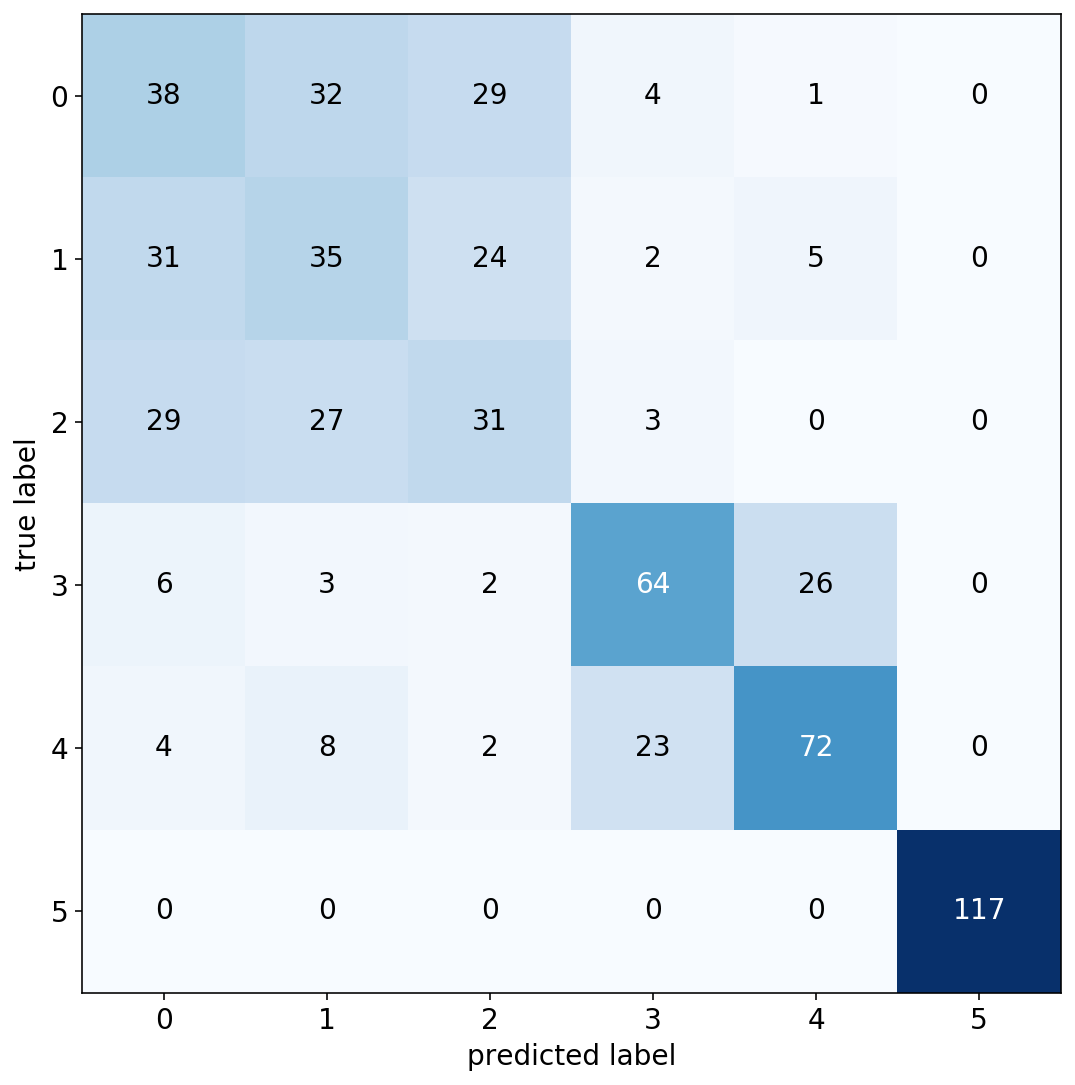

In [94]:
A = fisher_LDA(x_train, y_train, n_dim = 3)
clf1 = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf1.fit(x_train @ A, y_train)
y_pred_1 = clf1.predict(x_test @ A)
print('Accuracy for k=1: ' + str(accuracy_score(y_test, y_pred_1)))
confMatrix = confusion_matrix(y_test, y_pred_1)
print('Confusion matrix:')
fig, ax = plot_confusion_matrix(confMatrix)
plt.show()

Accuracy for k=1: 0.7233009708737864
Confusion matrix:


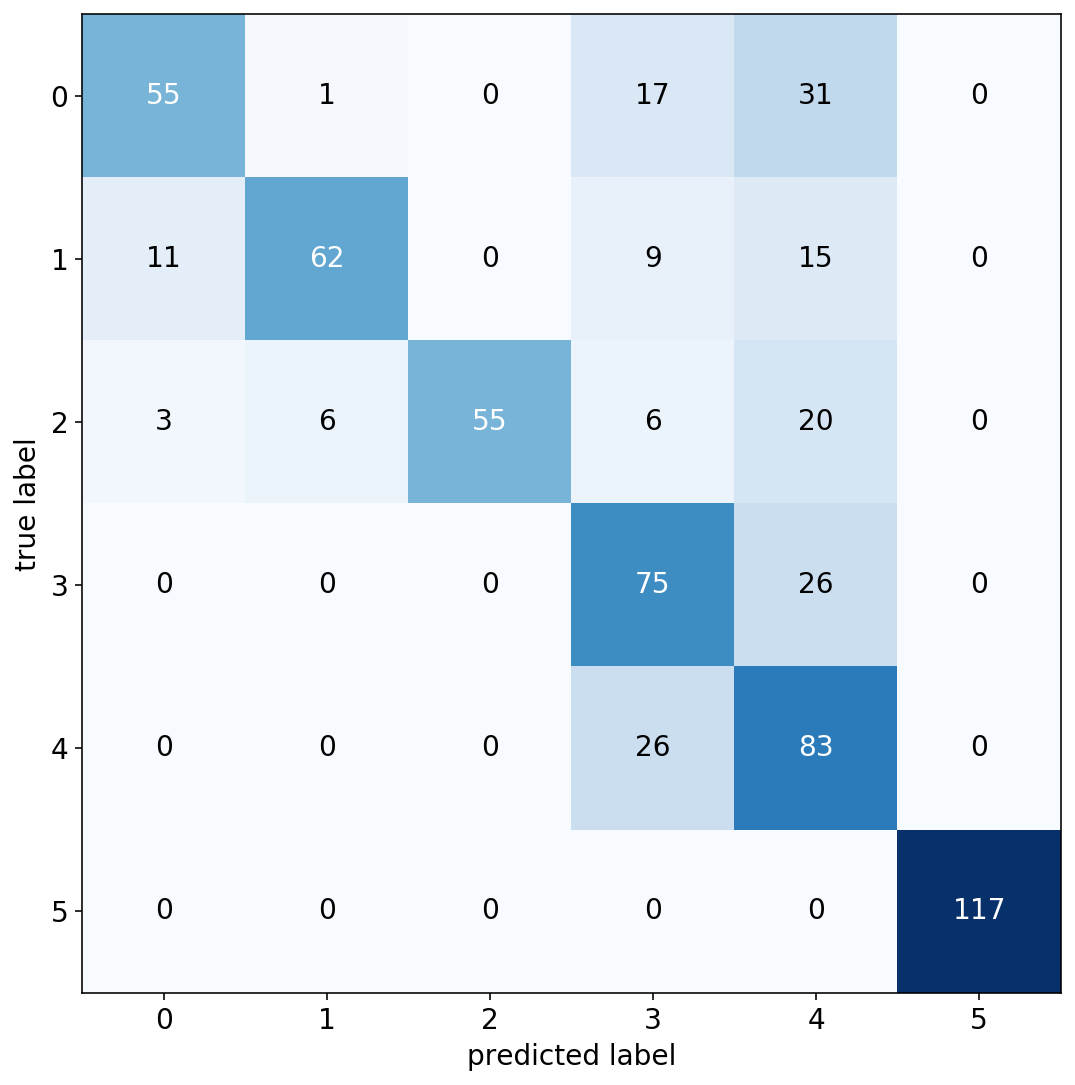

In [95]:
clf1 = KNeighborsClassifier(n_neighbors = 1, algorithm="brute")
clf1.fit(x_train , y_train)
y_pred_1 = clf1.predict(x_test )
print('Accuracy for k=1: ' + str(accuracy_score(y_test, y_pred_1)))
confMatrix = confusion_matrix(y_test, y_pred_1)
print('Confusion matrix:')
fig, ax = plot_confusion_matrix(confMatrix)
plt.show()

In [47]:
A.shape

(384, 3)

### Try Nu-SVM

In [1]:
from sklearn.svm import NuSVC
clf_SVM = NuSVC(gamma='scale')
clf_SVM.fit(x_train, y_train)
y_pred_SVM = clf_SVM.predict(x_test)
print('Accuracy for SVM: ' + str(accuracy_score(y_test, y_pred_SVM)))

NameError: name 'x_train' is not defined

In [30]:
clf_SVM.fit(x_train_dft, y_train)
y_pred_SVM = clf_SVM.predict(x_test_dft)
print('Accuracy for SVM_dft: ' + str(accuracy_score(y_test, y_pred_SVM)))

Accuracy for SVM: 0.8689320388349514


In [31]:
clf_SVM.fit(x_train_filted, y_train)
y_pred_SVM = clf_SVM.predict(x_test_filted)
print('Accuracy for SVM_filted: ' + str(accuracy_score(y_test, y_pred_SVM)))

Accuracy for SVM: 0.7233009708737864


In [32]:
clf_SVM.fit(x_train_filted_dft, y_train)
y_pred_SVM = clf_SVM.predict(x_test_filted_dft)
print('Accuracy for SVM_filted_dft: ' + str(accuracy_score(y_test, y_pred_SVM)))

Accuracy for SVM_filted_dft: 0.86084142394822
